# Approach and Contents:
The following notebook explains the approach I used for the Demand Forecasting problem Hosted on AnalyticsVidhya. Please check it out on https://datahack.analyticsvidhya.com/contest/janatahack-demand-forecasting/True/#About      

The problem needs us to predict the number of items sold for multiple products across multiple stores.       

*As we can understand, each product, store combination can be modelled as a separate time series. However, we can also build one model, treating the store id and item id as categorical features.*            

I have used both the approaches in the following notebook. For me, the latter approach(building one model treating store and item ids as categorical variables) gave the better result.          

**I made submissions after the competition ended and obtained Rank #17.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn import ensemble, linear_model, metrics, preprocessing, model_selection, feature_selection, pipeline
import lightgbm as lgb
import tsfresh
import matplotlib.pyplot as plt
import matplotlib as mpl
import catboost as cb
from skopt import gp_minimize, space, gbrt_minimize, dummy_minimize, forest_minimize
from functools import partial

/kaggle/input/demand-forecasting/train_0irEZ2H.csv
/kaggle/input/demand-forecasting/sample_submission_pzljTaX.csv
/kaggle/input/demand-forecasting/test_nfaJ3J5.csv


In [2]:
# Function to optimize hyperparameters using skopt. We will be tuning lightgbm
def optimize_sk(params, param_names, X, y, scoring, estimator, cv = model_selection.KFold(n_splits = 5)):
    '''params: list of param values
    param_names: param names
    x: training exogs
    y: training endogs
    return: negative metric after k fold validation'''

    params = dict(zip(param_names, params))

    # Initialize the model
    model = estimator(**params)

    kf = cv

    scores = []
    for train_index, test_index in kf.split(X, y):
        # Split Data
        X_train, y_train = np.array(X)[train_index, :], y[train_index]
        X_test, y_test = np.array(X)[test_index, :], y[test_index]

        # Fit model
        model.fit(X_train, y_train)

        # Evaluate model
        preds = model.predict(X_test)
        scores.append(scoring(y_test, preds))

    return np.mean(scores)

def rmse(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred)

# Parameter Space
param_space = [
    space.Integer(500, 2500, name = 'n_estimators'),
    space.Integer(2, 10, name = 'max_depth'),
    space.Real(0, 1, name = 'feature_fraction'),
    space.Integer(2, 25, name = 'min_data_in_leaf'),
    space.Real(.001, .4, name = 'learning_rate')
]

# Param names
names = ['n_estimators', 'max_depth', 'feature_fraction', 'min_data_in_leaf', 'learning_rate']

# Approach 1:
* Treat store_id and sku_id as categorical variables
* Create an ensemble model with simple and weighted averages

In [3]:
# To Create aggregation function  - If required
def ts_agg_feature(data, groupby, column, func = np.mean, suffix = 'agg'):
    return data.merge(data.groupby(groupby)[column].agg(func).reset_index(), on = groupby,
                     suffixes = ('', '_'+suffix+'_'+groupby))

In [4]:
train = pd.read_csv('/kaggle/input/demand-forecasting/train_0irEZ2H.csv')
test = pd.read_csv('/kaggle/input/demand-forecasting/test_nfaJ3J5.csv')
mpl.rcParams['font.size'] = 13

([<matplotlib.axis.YTick at 0x7f27fecfd450>,
 [Text(0, 0, 'test'), Text(0, 0, 'train')])

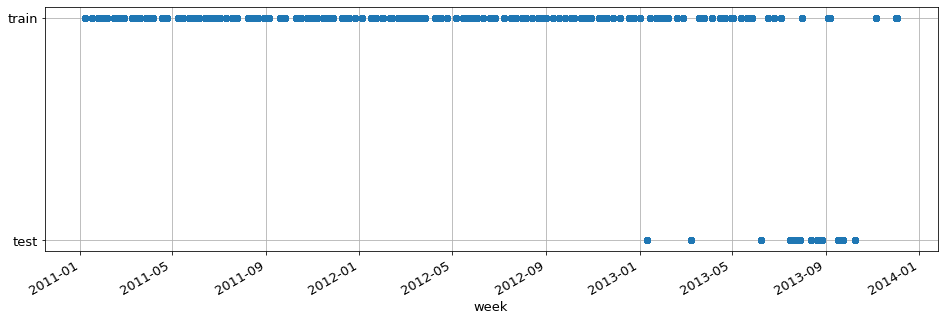

In [5]:
# Visualize the train test time positions
tr = train.copy()
te = test.copy()
tr['tt'] = 1
te['tt'] = 0

appended = pd.concat([tr[te.columns], te], axis = 0)
appended['week'] = pd.to_datetime(appended['week'])
appended = appended.set_index('week')
appended = appended.sort_index()

appended['tt'].plot.line(figsize = (16, 5), marker = 'o', linewidth = 0, grid = True)
plt.yticks([0, 1], ['test', 'train'])


In [6]:
train.head(1)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20


In [7]:
import datetime
def ts_features(data, col = 'week'):
    data['day'] = data[col].dt.day
    data['month'] = data[col].dt.month
    data['year'] = data[col].dt.year
    data['dayofweek'] = data[col].dt.dayofweek
    data['weekofyear'] = data[col].dt.weekofyear
    data['weekend'] = (data[col].dt.weekday >= 5).astype(int)
    data['weekofmonth'] = data[col].dt.day//7
    data['quarter'] = data[col].dt.quarter
    
    start_date = datetime.datetime(2011,1, 17)
    data['end_week_serial']  = [divmod((x-start_date).total_seconds(), 86400)[0]/7 for x in data['week']]
    return data


In [8]:
# Remove Outliers
def preprocess(data):
    data = data[data['units_sold'] < 200]
    return data

train = preprocess(train)

In [9]:
train2 = train.copy()
train2['week'] = pd.to_datetime(train2['week'])

x = 'base_price'
y = 'units_sold'


In [10]:
appended = pd.concat([tr[te.columns], te], axis = 0, ignore_index = True)
appended['week'] = pd.to_datetime(appended['week'])
appended = ts_features(appended)

appended = appended.set_index('week')

#appended = pd.get_dummies(appended, columns = ['store_id', 'sku_id'], drop_first = True)
appended['diff'] = appended['total_price'].values - appended['base_price'].values
appended['div_by_base'] = appended['diff'].values/appended['base_price'].values
appended['div_by_total'] = appended['diff'].values/appended['total_price'].values
#appended['base_total'] = appended['total_price'].values*appended['base_price'].values

appended
train = appended.loc[appended['tt'] == 1, :]
test = appended.loc[appended['tt'] == 0, :]

In [11]:
to_drop = ['record_ID', 'tt']
y_col = ['units_sold']

X, y = train.drop(to_drop, axis = 1), tr[y_col[0]]
xtest = test.drop(to_drop, axis = 1)

train.head()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,tt,day,month,year,dayofweek,weekofyear,weekend,weekofmonth,quarter,end_week_serial,diff,div_by_base,div_by_total
week,,,,,,,,,,,,,,,,,,,,
2011-01-17,1,8091,216418,99.0375,111.8625,0,0,1,17,1,2011,0,3,0,2,1,0.0,-12.825,-0.11465,-0.129496
2011-01-17,2,8091,216419,99.0375,99.0375,0,0,1,17,1,2011,0,3,0,2,1,0.0,0.000,0.00000,0.000000
2011-01-17,3,8091,216425,133.9500,133.9500,0,0,1,17,1,2011,0,3,0,2,1,0.0,0.000,0.00000,0.000000
2011-01-17,4,8091,216233,133.9500,133.9500,0,0,1,17,1,2011,0,3,0,2,1,0.0,0.000,0.00000,0.000000
2011-01-17,5,8091,217390,141.0750,141.0750,0,0,1,17,1,2011,0,3,0,2,1,0.0,0.000,0.00000,0.000000


In [12]:
X = X.fillna(X.median())

In [13]:
X.head(2)

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,day,month,year,dayofweek,weekofyear,weekend,weekofmonth,quarter,end_week_serial,diff,div_by_base,div_by_total
week,,,,,,,,,,,,,,,,,,
2011-01-17,8091,216418,99.0375,111.8625,0,0,17,1,2011,0,3,0,2,1,0.0,-12.825,-0.11465,-0.129496
2011-01-17,8091,216419,99.0375,99.0375,0,0,17,1,2011,0,3,0,2,1,0.0,0.000,0.00000,0.000000


In [14]:
# Tune Model
# Define objective - reformat it in terms of what is required for skopt
objective_optimization = partial(optimize_sk, param_names = names, X = X, y = np.log1p(y), 
                                scoring = rmse, estimator = partial(lgb.LGBMRegressor, cat_columns = ['store_id', 'sku_id']))

# Perform Optimization
#gbrt_minimize, dummy_minimize, forest_minimize
skopt_optimization = forest_minimize(func = objective_optimization, 
                                dimensions = param_space, n_calls = 35,  
                                x0 = None, y0 = None, random_state = 10, 
                                verbose = 10)
#print(skopt_optimization)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 49.1213
Function value obtained: 0.2212
Current minimum: 0.2212
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.2362
Function value obtained: 0.3063
Current minimum: 0.2212
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 24.6682
Function value obtained: 0.2515
Current minimum: 0.2212
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 23.0437
Function value obtained: 0.2309
Current minimum: 0.2212
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 40.8702
Function value obtained: 0.2425
Current minimum: 0.2212
Iteration No: 6 started. Evalu

In [15]:
# Calculate k fold averaged MSE - we will use this while training the ensemble model
splitter = model_selection.KFold(5)

def validate(estimator, X, y, cv = splitter, split = None):
    if split is None:
        split = y
        
    scores = []
    for train_index, test_index in splitter.split(X, split):
        xtr, xte = np.array(X)[train_index, :], np.array(X)[test_index, :]
        ytr, yte = np.array(y)[train_index], np.array(y)[test_index]
        xtr = pd.DataFrame(xtr, columns = X.columns)
        xtr['store_id'] = xtr['store_id'].astype(int)
        xtr['sku_id'] = xtr['sku_id'].astype(int)
        
        xte = pd.DataFrame(xte, columns = X.columns)
        xte['store_id'] = xte['store_id'].astype(int)
        xte['sku_id'] = xte['sku_id'].astype(int)
        model = estimator.fit(xtr, ytr)
        
        scores.append(metrics.mean_squared_error(yte, model.predict(xte)))
        
        
    return np.mean(scores)



In [16]:
# Model 1 - Catboost
model1 = cb.CatBoostRegressor(iterations = 2000, learning_rate = .02, max_depth = 8, 
                             cat_features = ['store_id', 'sku_id'], objective = 'RMSE', verbose = 0)
wt1 = 1/validate(model1, X, np.log1p(y), )

# Model 2 - lightgbm
model2 = lgb.LGBMRegressor(**dict(zip(names, skopt_optimization.x)))
wt2 = 1/validate(model2, X, np.log1p(y), )

# Weigh the ensemble models by inverse of their mse
model = ensemble.VotingRegressor([('catboost', model1), ('lgb', model2)], n_jobs = -1,
                                 weights = [wt1, wt2]).fit(X, np.log1p(y))

# Without weighing - ensemble simple average
#model = ensemble.VotingRegressor([('catboost', model1), ('lgb', model2)], n_jobs = -1).fit(X, np.log1p(y))
pred = model.predict(xtest)

preds = pd.DataFrame()
preds['record_ID'] = te['record_ID']
preds['units_sold'] = np.abs(np.exp(pred))
preds.to_csv('SubA.csv', index = None)

## Utility Functions

## Use rfpimp package to Calculate Feature importance. The following importances can be calculated:
* Permutation importance
* Drop Column Importance        

It is recommended to use permutation importance and drop-column importance to calculate feature importances instead of using the default gini-index based measure. 

Please view the following link to read more about the above methods and why they are preferable options:        
https://github.com/parrt/random-forest-importances 

     |████████████████████████████████| 160 kB 8.5 MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.5-py3-none-any.whl size=10257 sha256=41c2204945dfedc38b0705f3019052175448d959d2af58105b71014f7d1dd436
  Stored in directory: /root/.cache/pip/wheels/15/88/ae/4e8850abc5088fd7e50cc7f869450d6085a0ec6d245adf8874
  Created wheel for stratx: filename=stratx-0.4.1-py3-none-any.whl size=35079 sha256=beefad3f04994ab5af89065c2cd387401f84086547dc4c2750d09c837ff7e78f
  Stored in directory: /root/.cache/pip/wheels/88/85/01/fa1a3072052c9b027e3c40654b5dc8a488be8afc07442f39e0
Successfully built rfpimp stratx


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


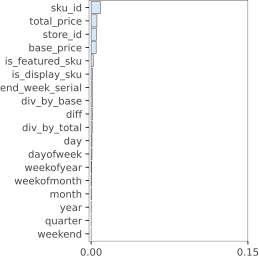

In [17]:
import sys
!{sys.executable} -m pip install rfpimp

import rfpimp

# View Permutation importance of features
imps = rfpimp.importances(model = model, X_valid = X, y_valid = y)
rfpimp.plot_importances(imps)

# Approach 2: Create separate models for each store, sku combination. 
This would result in creating 1155 models. While predicting on test data, we note down the store, sku combination and fetch the corresponding model.
This approach performed worse than the approach mentioned above. One reason could be that this approach does not allow interaction effects between stores and skus between stores. 

In [18]:
from tqdm.notebook import tqdm

In [19]:
train = pd.read_csv('/kaggle/input/demand-forecasting/train_0irEZ2H.csv')
test = pd.read_csv('/kaggle/input/demand-forecasting/test_nfaJ3J5.csv')
mpl.rcParams['font.size'] = 13

In [20]:
train['week'] = pd.to_datetime(train['week'])
test['week'] = pd.to_datetime(test['week'])

In [21]:
train = train.fillna(train.median())


In [22]:
import datetime
def ts_features(data, col = 'week'):
    data['day'] = data[col].dt.day
    data['month'] = data[col].dt.month
    data['year'] = data[col].dt.year
    data['dayofweek'] = data[col].dt.dayofweek
    data['weekofyear'] = data[col].dt.weekofyear
    data['weekend'] = (data[col].dt.weekday >= 5).astype(int)
    data['weekofmonth'] = data[col].dt.day//7
    data['quarter'] = data[col].dt.quarter
    
    return data

traints = ts_features(train)
testts = ts_features(test)

In [23]:
rec_id_test = testts['record_ID']

In [24]:
models = {}

# Store store, sku combinations present in data
indices = traints.groupby(['store_id', 'sku_id']).mean().index.tolist()

In [25]:
traints.head(1)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day,month,year,dayofweek,weekofyear,weekend,weekofmonth,quarter
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,17,1,2011,0,3,0,2,1


In [26]:
xcols = ['total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'day', 'month',
       'year', 'dayofweek', 'weekofyear', 'weekend','weekofmonth']

traints = traints.fillna(traints.median())
traints.head(2)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day,month,year,dayofweek,weekofyear,weekend,weekofmonth,quarter
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,17,1,2011,0,3,0,2,1
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17,1,2011,0,3,0,2,1


In [27]:
# Define transform and Inverse transform for y
def y_transform(x):
    return np.log(x)

def inverse_y(x):
    return np.exp(x)

# Simple Non Lagged Features

In [28]:
xs, ys = {}, {}

for count, combo in tqdm(enumerate(indices)):
    temp = traints.loc[(traints['store_id'] == indices[count][0])&(traints['sku_id'] == indices[count][1]), :]
    
    # Define model
    model = lgb.LGBMRegressor(n_estimators = 100, max_depth = 3, learning_rate = 0.05, max_features = .8)
    Xtemp = temp[xcols]
    ytemp = temp['units_sold']
    
    # Store x
    xs[combo] = Xtemp
    ys[combo] = ytemp
    
    # Store model for that store, sku combination
    models[(indices[count][0], indices[count][1])] = model.fit(Xtemp, y_transform(ytemp))
    

In [29]:
preds = pd.DataFrame()
preds['record_ID'] = rec_id_test
preds['units_sold'] = np.abs(pred)
preds.to_csv('SubA.csv', index = None)